## Create a model to predict the 2019 March Madness Mens Tournament outcomes

The goal is as stated in the title, to create a model that will best predict the 2019 March Madness Mens Tournament outcomes. This model will be able to predict the outcome to every possible matchup as a likelihood ration, which will then be used to determine the winner of each game in the bracket.

#### Inspiration

Originally, I had joined the Kaggle competition "Google Cloud & NCAA® ML Competition 2020-NCAAM", which was then canceled due to COVID-19. Since I had poured weeks of work into this competition, I decided to utilize my work to predict the 2019 competition bracket and use the results to test its accuracy (not training on any 2019 tournament data).

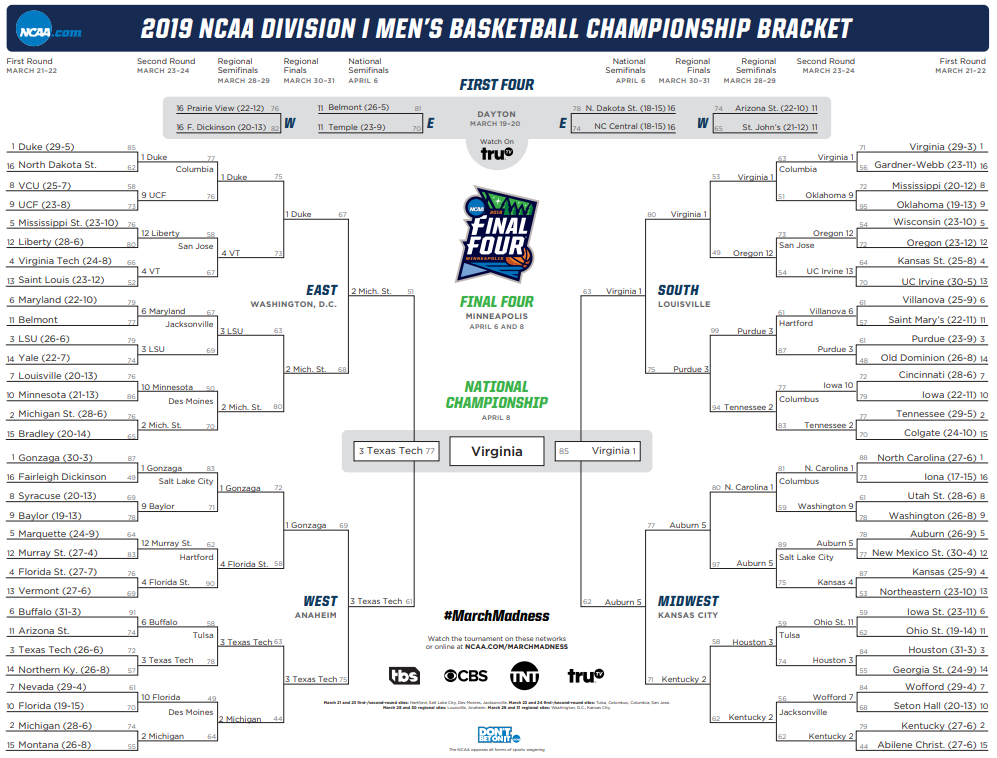

## Import packages and load all data into dataframes

In [2]:
# Import all necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
#import xgboost as xgb
import matplotlib.pyplot as plt
import datetime
import calendar
import time

%matplotlib inline

In [3]:
# for stepping through files in a folder
import glob

In [4]:
Mplayers = pd.read_csv('data/MEvents_NCAA_2020_Comp/MPlayers.csv')

In [5]:
# Load all play-by-play data, which is only available for the 2015-current seasons
df15 = pd.read_csv('data/MEvents_NCAA_2020_Comp/MEvents2015.csv')
df16 = pd.read_csv('data/MEvents_NCAA_2020_Comp/MEvents2016.csv')
df17 = pd.read_csv('data/MEvents_NCAA_2020_Comp/MEvents2017.csv')
df18 = pd.read_csv('data/MEvents_NCAA_2020_Comp/MEvents2018.csv')
df19 = pd.read_csv('data/MEvents_NCAA_2020_Comp/MEvents2019.csv')

# Combine all datasets into a main "Event_df"
Event_df = pd.concat([df15, df16, df17, df18, df19], axis=0)

In [6]:
Event_df.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,1,2015,11,1103,1420,74,57,0,0,19,1103,100,miss3,unk,0,0,0
1,2,2015,11,1103,1420,74,57,0,0,19,1420,11784,reb,def,0,0,0
2,3,2015,11,1103,1420,74,57,0,0,27,1420,11789,made2,dunk,0,0,0
3,4,2015,11,1103,1420,74,57,0,0,27,1420,11803,assist,NaN,0,0,0
4,5,2015,11,1103,1420,74,57,0,0,59,1103,87,made2,jump,0,0,0


In [7]:
# Review the shape() and describe() methods of the dataset
print(f'Shape: {Event_df.shape}')
Event_df.describe()

Shape: (13149684, 17)


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,X,Y,Area
count,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07,1.314968e+07
mean,6.574842e+06,2.017017e+03,7.113859e+01,1.288749e+03,1.280575e+03,7.783179e+01,6.586363e+01,2.761638e+00,2.304507e+00,1.273283e+03,1.279920e+03,6.316912e+03,1.212857e+00,1.224811e+00,1.281918e-01
std,3.795987e+06,1.414644e+00,3.740059e+01,1.042811e+02,1.034486e+02,1.115825e+01,1.117254e+01,1.187522e+01,9.994342e+00,7.059115e+02,1.307764e+02,4.059274e+03,9.540931e+00,8.378616e+00,1.046556e+00
min,1.000000e+00,2.015000e+03,1.000000e+00,1.101000e+03,1.101000e+03,3.800000e+01,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.287422e+06,2.016000e+03,3.700000e+01,1.202000e+03,1.190000e+03,7.000000e+01,5.800000e+01,0.000000e+00,0.000000e+00,6.600000e+02,1.195000e+03,2.745000e+03,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.574842e+06,2.017000e+03,7.300000e+01,1.290000e+03,1.279000e+03,7.700000e+01,6.600000e+01,0.000000e+00,0.000000e+00,1.273000e+03,1.283000e+03,6.272000e+03,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.862263e+06,2.018000e+03,1.030000e+02,1.381000e+03,1.369000e+03,8.500000e+01,7.300000e+01,0.000000e+00,0.000000e+00,1.886000e+03,1.374000e+03,9.860000e+03,0.000000e+00,0.000000e+00,0.000000e+00
max,1.314968e+07,2.019000e+03,1.520000e+02,1.466000e+03,1.466000e+03,1.440000e+02,1.270000e+02,1.180000e+02,1.170000e+02,3.600000e+03,1.466000e+03,1.333800e+04,1.000000e+02,1.000000e+02,1.300000e+01


In [8]:
# Check how many missing values are in each column
Event_df.isnull().sum()

EventID                 0
Season                  0
DayNum                  0
WTeamID                 0
LTeamID                 0
WFinalScore             0
LFinalScore             0
WCurrentScore           0
LCurrentScore           0
ElapsedSeconds          0
EventTeamID             0
EventPlayerID           0
EventType               0
EventSubType      1324605
X                       0
Y                       0
Area                    0
dtype: int64

##### For now, we will ignore these missing values since they are only a sub category of a primary category (`EventType`) and may not serve a purpose.

In [9]:
# Load all data into a dictionary from the main folder
data_dict = {}
for i in glob.glob('data\\MEvents_NCAA_2020_Comp\\MDataFiles_Stage1\\*'):
    name = i.split('\\')[-1].split('.')[0]
    if name != 'MTeamSpellings':
        data_dict[name] = pd.read_csv(i)
    else:
        data_dict[name] = pd.read_csv(i, encoding='cp1252')

In [10]:
# Print out each dataset name and their columns for reference
for key in data_dict.keys():
    print(f'Key:{key} : {data_dict[key].columns} \n')

Key:Cities : Index(['CityID', 'City', 'State'], dtype='object') 

Key:Conferences : Index(['ConfAbbrev', 'Description'], dtype='object') 

Key:MConferenceTourneyGames : Index(['Season', 'ConfAbbrev', 'DayNum', 'WTeamID', 'LTeamID'], dtype='object') 

Key:MGameCities : Index(['Season', 'DayNum', 'WTeamID', 'LTeamID', 'CRType', 'CityID'], dtype='object') 

Key:MMasseyOrdinals : Index(['Season', 'RankingDayNum', 'SystemName', 'TeamID', 'OrdinalRank'], dtype='object') 

Key:MNCAATourneyCompactResults : Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT'],
      dtype='object') 

Key:MNCAATourneyDetailedResults : Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object') 

Key:MNCA

In [11]:
data_dict['MSeasons'].head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


## DATA WRANGLING AND EXPLORATION
#### Let's start to explore the data a bit. First I am going to look into the game frequency during the week vs. weekend.

In [12]:
def findDay(date):
    '''
    This function will return the corresponding weekday with the datetime object in column DayZero
    '''
    numday = datetime.datetime.strptime(date, '%m/%d/%Y').weekday()
    return calendar.day_name[numday]

In [13]:
# An example of what the above function will produce
exdate = data_dict['MSeasons']['DayZero'][0] #'10/29/1984'
calendar.day_name[datetime.datetime.strptime(exdate, '%m/%d/%Y').weekday()]

'Monday'

In [14]:
# Apply the function to the Data Frame 'MSeason' on column 'DayZero'
data_dict['MSeasons']['DZ_dayname'] = data_dict['MSeasons']['DayZero'].apply(lambda x: findDay(x))

In [15]:
data_dict['MSeasons'].DZ_dayname.unique()

array(['Monday'], dtype=object)

As we see here, all of the seasons start on a ***Monday***. Knowing this, we will create a function that will give a weekday name to each of the numbers in the `DayNum` column of any Data Frame.

In [16]:
# we want to find out what day of the week a game was played
def weekday(day):
    '''
    This function will return a weekday name to each of the numerical values in the column 'DayNum'
    '''
    if day%7 == 0:
        return 'Monday'
    elif day%7 == 1:
        return 'Tuesday'
    elif day%7 == 2:
        return 'Wednesday'
    elif day%7 == 3:
        return 'Thursday'
    elif day%7 == 4:
        return 'Friday'
    elif day%7 == 5:
        return 'Saturday'
    elif day%7 == 6:
        return 'Sunday'

In [17]:
# apply weekday() and create a new column 'dayname'
data_dict['MRegularSeasonCompactResults']['dayname'] = data_dict['MRegularSeasonCompactResults']['DayNum'].apply(lambda x:
                                                                                                                 weekday(x)
                                                                                                                )

In [18]:
data_dict['MRegularSeasonCompactResults'].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,dayname
0,1985,20,1228,81,1328,64,N,0,Sunday
1,1985,25,1106,77,1354,70,H,0,Friday
2,1985,25,1112,63,1223,56,H,0,Friday
3,1985,25,1165,70,1432,54,H,0,Friday
4,1985,25,1192,86,1447,74,H,0,Friday


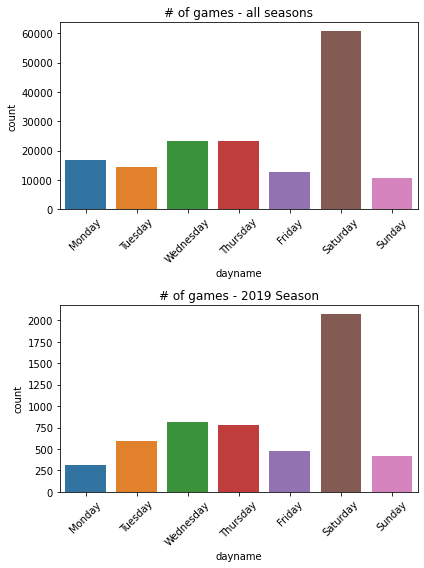

In [19]:
plt.figure(figsize=(6, 8))
weekday_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

plt.subplot(2,1,1)
sns.countplot(data_dict['MRegularSeasonCompactResults'].dayname, order=weekday_order)
plt.xticks(rotation=45)
plt.title('# of games - all seasons')

plt.subplot(2,1,2)
sns.countplot(data_dict['MRegularSeasonCompactResults'][data_dict['MRegularSeasonCompactResults'].Season == 2019].dayname,
             order=weekday_order)
plt.xticks(rotation=45)
plt.title('# of games - 2019 Season')
plt.tight_layout()

The above plots show that, for all seasons, the majority of games are played on ***Saturday***, and that weekday games are primarily on Wednesday and Thursday.

We can use this information to see if teams play better during the week or weekend.

---
#### Now we will perform the same on the detailed dataset.

In [20]:
# Add the day name that the game was played on
reg_szn = data_dict['MRegularSeasonDetailedResults']
reg_szn['day_name'] = reg_szn['DayNum'].apply(lambda x: weekday(x))

In [21]:
reg_szn.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name
0,2003,10,1104,68,1328,62,N,0,27,58,...,16,22,10,22,8,18,9,2,20,Thursday
1,2003,10,1272,70,1393,63,N,0,26,62,...,9,20,20,25,7,12,8,6,16,Thursday
2,2003,11,1266,73,1437,61,N,0,24,58,...,14,23,31,22,9,12,2,5,23,Friday
3,2003,11,1296,56,1457,50,N,0,18,38,...,8,15,17,20,9,19,4,3,23,Friday
4,2003,11,1400,77,1208,71,N,0,30,61,...,17,27,21,15,12,10,7,1,14,Friday


In [22]:
# figure out if the winning team won on the weekend or weekday
def weekend(day):
    if day == 'Friday' or day =='Saturday' or day == 'Sunday':
        return 1
    else:
        return 0

In [23]:
reg_szn['weekend_game'] = reg_szn['day_name'].apply(lambda x: weekend(x))

In [24]:
reg_szn.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name,weekend_game
0,2003,10,1104,68,1328,62,N,0,27,58,...,22,10,22,8,18,9,2,20,Thursday,0
1,2003,10,1272,70,1393,63,N,0,26,62,...,20,20,25,7,12,8,6,16,Thursday,0
2,2003,11,1266,73,1437,61,N,0,24,58,...,23,31,22,9,12,2,5,23,Friday,1
3,2003,11,1296,56,1457,50,N,0,18,38,...,15,17,20,9,19,4,3,23,Friday,1
4,2003,11,1400,77,1208,71,N,0,30,61,...,27,21,15,12,10,7,1,14,Friday,1


Data that I want to get features for - feature organization must be based on a per team/season basis

    - total score for each team/season
    - average score for each team/season
    - seed of each team
    - seed differential of the teams playing
    - win on a weekday/weekend
    - number of wins on a weekday/weekend
    - ranking differential based on ranking before game played, and end of season ranking differential for that game
    - upset for ranking during season
        - average these ranking features out for all ranking systems (or find most credible ranking systems)
    - look into hot streak towards the end of season/conference tourney 
    - look into how many 3 pointers were made per game, if that led to more wins
    - look into other player stats that could be incorporated
    - incorporate which conference each team was in - have this be a categorical feature
    - analyze the offense vs defense of a team in terms of event frequency
        - offense: FG's made frequency within a game (1st vs 4th quarter)
        - defense: rebounds, steals - frequency within a game (1st vs 4th quarter)
        - defense: deadball rebounds are when offense misses FT and goes out (team rebound)
    
The idea should be to get info for every team throughout all of the seasons and regular play, conference tournaments, and then depending on which teams made it to the tournament, pull all of their information from this database.
    

Text(0.5, 1.0, 'Points per game average per season')

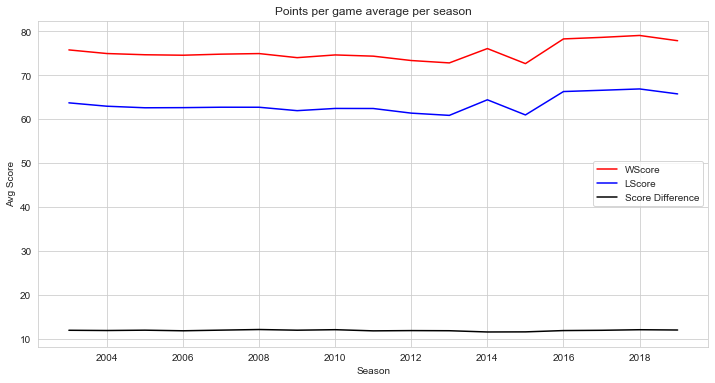

In [25]:
# Now lets create a plot to see the average scores per season for winning teams and losing teams
sns.set_style('whitegrid')
wscore = data_dict['MRegularSeasonDetailedResults'].groupby('Season').mean()['WScore']
lscore = data_dict['MRegularSeasonDetailedResults'].groupby('Season').mean()['LScore']
wscore.plot(figsize=(12,6), legend=True, color='red')
lscore.plot(figsize=(12,6), legend=True, color='blue')
(wscore-lscore).plot(legend=True, color='black', label='Score Difference')
plt.ylabel('Avg Score')
plt.title('Points per game average per season')

This is a very weird observation actually... It seems that the average score difference for each season since 1985 has been roughly 12 points.

In [26]:
# possible feature
# use this to pull how many weekend games a team won during a season
reg_szn.groupby(['Season','WTeamID'])['weekend_game'].sum()

Season  WTeamID
2003    1102        7
        1103        8
        1104       10
        1105        3
        1106        8
                   ..
2019    1462        9
        1463       16
        1464        7
        1465        5
        1466        2
Name: weekend_game, Length: 5829, dtype: int64

In [27]:
# possible feature
# use this to pull mean scores per a season
reg_szn.groupby(['Season','WTeamID'])['WScore'].mean()

Season  WTeamID
2003    1102       68.750000
        1103       87.769231
        1104       74.705882
        1105       79.428571
        1106       68.307692
                     ...    
2019    1462       76.944444
        1463       83.761905
        1464       78.100000
        1465       80.083333
        1466       71.000000
Name: WScore, Length: 5829, dtype: float64

In [28]:
# use this to pull average ranking for a team per season
data_dict['MMasseyOrdinals'].groupby(['TeamID','Season'])['OrdinalRank'].mean()

TeamID  Season
1101    2014      331.861004
        2015      316.927044
        2016      317.866505
        2017      284.805836
        2018      247.100484
                     ...    
1464    2017      274.084175
        2018      321.853333
        2019      289.747300
1465    2019      226.581878
1466    2019      311.457923
Name: OrdinalRank, Length: 5834, dtype: float64

**In the following few windows, we will take out any game that is played before the first ranking of the season**

In [29]:
szn_startrank = data_dict['MMasseyOrdinals'].groupby('Season').min()
szn_startrank

,RankingDayNum,SystemName,TeamID,OrdinalRank
Season,,,,
2003,35,AP,1102,1
2004,13,AP,1102,1
2005,16,ACU,1102,1
2006,13,ACU,1102,1
2007,37,ACU,1102,1
2008,1,AP,1102,1
2009,6,AP,1102,1
2010,8,AP,1102,1
2011,0,AP,1102,1


In [30]:
# trying to pull games that are played while there are rankings posted
# start by building a df for this
reg_szn_RO = reg_szn
reg_szn_RO.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name,weekend_game
0,2003,10,1104,68,1328,62,N,0,27,58,...,22,10,22,8,18,9,2,20,Thursday,0
1,2003,10,1272,70,1393,63,N,0,26,62,...,20,20,25,7,12,8,6,16,Thursday,0
2,2003,11,1266,73,1437,61,N,0,24,58,...,23,31,22,9,12,2,5,23,Friday,1
3,2003,11,1296,56,1457,50,N,0,18,38,...,15,17,20,9,19,4,3,23,Friday,1
4,2003,11,1400,77,1208,71,N,0,30,61,...,27,21,15,12,10,7,1,14,Friday,1


In [31]:
# filter out games that are played before the first ranking of the season.
new_df = pd.DataFrame()
for szn in szn_startrank.index:
    df2 = reg_szn_RO[(reg_szn_RO['Season']==szn) & (reg_szn_RO['DayNum']>=szn_startrank['RankingDayNum'][szn])]
    new_df = pd.concat([new_df, df2])
reg_szn_ro = new_df

In [32]:
reg_szn_ro.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name,weekend_game
778,2003,35,1105,97,1366,78,H,0,28,61,...,15,22,17,14,22,6,3,24,Monday,0
779,2003,35,1107,47,1119,43,A,0,15,47,...,7,8,23,10,19,3,2,18,Monday,0
780,2003,35,1110,61,1224,58,H,0,20,50,...,10,16,25,7,15,6,0,21,Monday,0
781,2003,35,1187,76,1439,60,H,0,25,48,...,7,14,20,12,20,5,4,24,Monday,0
782,2003,35,1231,73,1435,56,H,0,25,59,...,7,18,22,12,14,10,3,17,Monday,0


In [33]:
# Check how many entries we have eliminated
dif = len(reg_szn) - len(reg_szn_ro)
pct = 100 * dif / len(reg_szn)
print(f'Entries eliminated: {dif}\nPCT eliminated: {pct}')

Entries eliminated: 3841
PCT eliminated: 4.389513622234412


**Now we have our 2 data frames for the next step:**

    reg_szn - all games played
    reg_szn_ro - only games played since the first ranking

In [34]:
# we will use this ranking list to see the ranking differential during games in the 
rank_regszn_list = data_dict['MMasseyOrdinals'].groupby(['Season','TeamID','RankingDayNum'])['OrdinalRank'].mean()
rank_regszn_list

Season  TeamID  RankingDayNum
2003    1102    35               159.000000
                37               118.000000
                42               191.000000
                43               108.000000
                44                88.866667
                                    ...    
2019    1466    107              311.828125
                114              310.435484
                121              302.111111
                128              304.285714
                133              303.111111
Name: OrdinalRank, Length: 224628, dtype: float64

In [35]:
# pull rank of each team from average ranking from the most recent rank
# we will use this to determine if the game was an upset or not

def rank_regszn(season, team, daynum):
    
    ''' THIS IS TO ONLY BE USED FOR THE RANKED MODIFIED REGSZN DATAFRAME'''
    
    # list is grouped by Season, TeamID, RankingDayNum
    if daynum in rank_regszn_list[season, team].index:
        # print('working')
        return rank_regszn_list[season, team, daynum]
    else:
        # subtract 1 to get to the previous rank before the game
        while daynum < 134:
            if daynum in rank_regszn_list[season, team].index:
                return rank_regszn_list[season, team, daynum]
            else:
                daynum -= 1
                if daynum in rank_regszn_list[season, team].index:
                    return rank_regszn_list[season, team, daynum]
                else:
                    daynum -=1
            
            # This will catch any teams that arent ranked before DayNum game
            if daynum < 0:
                lst = rank_regszn_list[season, team].index
                daynum = lst[min(range(len(lst)), key=lambda x: abs(lst[x]-daynum))]
                return rank_regszn_list[season, team, daynum]

In [36]:
# Create columns for the Winners and Losers season rank, and the season differential
reg_szn_ro['Wszn_rank'] = reg_szn_ro.apply(lambda x: rank_regszn(x['Season'], x['WTeamID'], x['DayNum']), axis=1)
reg_szn_ro['Lszn_rank'] = reg_szn_ro.apply(lambda x: rank_regszn(x['Season'], x['LTeamID'], x['DayNum']), axis=1)
reg_szn_ro['szn_rank_diff'] = reg_szn_ro.apply(lambda x: x['Wszn_rank']-x['Lszn_rank'], axis=1)

In [98]:
# determine if a game was an upset or not
def upset(rank_diff):
    if rank_diff > 0:
        return 1
    else:
        return 0

In [99]:
reg_szn_ro['upset'] = reg_szn_ro['szn_rank_diff'].apply(lambda x: upset(x))

In [100]:
# Check to see the percent of gmaes that are won by the lower rank team
100 * reg_szn_ro.upset.sum() / len(reg_szn_ro)

29.002067819705246

#### Interesting that 29% of games are upsets (in terms of ranking)

In [101]:
reg_szn_ro.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name,weekend_game,Wszn_rank,Lszn_rank,szn_rank_diff,upset
778,2003,35,1105,97,1366,78,H,0,28,61,8,23,33,41,16,23,15,18,11,3,20,32,71,4,11,10,15,22,17,14,22,6,3,24,Monday,0,314.0,313.0,1.0,1
779,2003,35,1107,47,1119,43,A,0,15,47,7,22,10,15,13,15,6,13,6,3,13,17,40,4,9,5,7,8,23,10,19,3,2,18,Monday,0,249.0,318.0,-69.0,0
780,2003,35,1110,61,1224,58,H,0,20,50,11,27,10,20,9,25,16,17,5,2,20,25,62,3,16,5,10,16,25,7,15,6,0,21,Monday,0,204.0,285.0,-81.0,0
781,2003,35,1187,76,1439,60,H,0,25,48,6,17,20,28,6,22,13,12,8,3,13,23,58,10,27,4,7,14,20,12,20,5,4,24,Monday,0,18.0,184.0,-166.0,0
782,2003,35,1231,73,1435,56,H,0,25,59,10,25,13,14,13,28,15,14,6,10,9,26,69,1,15,3,7,18,22,12,14,10,3,17,Monday,0,1.0,82.0,-81.0,0


In [102]:
reg_szn_ro.isnull().sum()

Season           0
DayNum           0
WTeamID          0
WScore           0
LTeamID          0
LScore           0
WLoc             0
NumOT            0
WFGM             0
WFGA             0
WFGM3            0
WFGA3            0
WFTM             0
WFTA             0
WOR              0
WDR              0
WAst             0
WTO              0
WStl             0
WBlk             0
WPF              0
LFGM             0
LFGA             0
LFGM3            0
LFGA3            0
LFTM             0
LFTA             0
LOR              0
LDR              0
LAst             0
LTO              0
LStl             0
LBlk             0
LPF              0
day_name         0
weekend_game     0
Wszn_rank        0
Lszn_rank        0
szn_rank_diff    0
upset            0
dtype: int64

### Review the scoring in a game for events from 2015 - 2019

In [103]:
Event_df.EventType.unique()

array(['miss3', 'reb', 'made2', 'assist', 'turnover', 'steal', 'foul',
       'miss2', 'made3', 'timeout', 'sub', 'made1', 'miss1', 'block',
       'fouled', 'jumpb'], dtype=object)

#### We will review all of the "made" events and look at the scoring frequency throughout the game

In [104]:
# create a DF that is only for seasons 2015 and above
reg_szn_15_19 = reg_szn_ro[reg_szn_ro['Season']>=2015]

In [105]:
# Example of what information we are extracting
# this can be used to figure out how many 2 pointers were made in the first 10 minutes of the game
np.sum(df19[(df19['DayNum']==1) & (df19['WTeamID']==1104) & (df19['ElapsedSeconds']<=1200)]['EventType']=='made2')

15

In [106]:
# create a function that will extract the score made for a specific event type
def made_score(EventType):
    if 'made' in EventType:
        return int(EventType.split('made')[1])
    else:
        return 0

In [107]:
Event_df['made'] = Event_df['EventType'].apply(lambda x: made_score(x))

In [108]:
Event_df[['EventType','made']].head()

,EventType,made
0,miss3,0
1,reb,0
2,made2,2
3,assist,0
4,made2,2


In [109]:
# Create dataframes of events accumulated at 3 different durations throughout the game.
# A college basketball game consits of two 20 minute halves (600 seconds = 10 minutes = 1st quarter of game duration)
eventscores_half = Event_df.loc[Event_df['ElapsedSeconds']<=1200].groupby(['Season', 'DayNum','EventTeamID']).sum()['made'].copy()

In [110]:
# trying method 3 but with less df arguments, and a group by case

def scoring_freq(season, daynum, team):
    
    # set correct table for pulling data from
    es = eventscores_half
    # set variable 'div' to 2, incase a teams value is not in the table - which by the data default is '0'
    # this will divide the final score by 2 to get an approximation of score at halftime
    div = 2
    
    if team in es[season, daynum].index:
        return es[season, daynum, team]
    elif 0 in es[season, daynum].index:
        team = 0
        return es[season, daynum, team]/div
    else:
        return None

##### Note:

In [111]:
# Need to set 'chained_assignment' value to None, kept getting the "SettingWithCopyWarning"
#
# "A value is trying to be set on a copy of a slice from a DataFrame.
#  Try using .loc[row_indexer,col_indexer] = value instead"

pd.set_option('mode.chained_assignment', None)

In [112]:
# make columns for winning team scoring frequency
reg_szn_15_19['W_sf_half'] = reg_szn_15_19.apply(lambda x: scoring_freq(x['Season'], x['DayNum'], x['WTeamID']), axis=1)

# make columns for loosing team scoring frequency
reg_szn_15_19['L_sf_half'] = reg_szn_15_19.apply(lambda x: scoring_freq(x['Season'], x['DayNum'], x['LTeamID']), axis=1)

In [113]:
reg_szn_15_19.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name,weekend_game,Wszn_rank,Lszn_rank,szn_rank_diff,upset,W_sf_half,L_sf_half
60795,2015,16,1107,65,1312,48,H,0,22,56,5,20,16,19,9,36,9,16,10,4,21,15,53,6,28,12,21,10,28,10,18,4,0,17,Wednesday,0,176.692308,302.076923,-125.384615,0,36.0,17.0
60796,2015,16,1112,71,1414,54,H,0,19,48,4,14,29,34,13,27,11,13,11,5,14,20,54,5,15,9,13,10,20,12,15,4,1,24,Wednesday,0,5.125000,90.923077,-85.798077,0,26.0,29.0
60797,2015,16,1116,83,1448,53,H,0,32,61,7,15,12,18,11,25,18,12,13,4,19,19,59,1,18,14,18,16,20,11,20,4,0,16,Wednesday,0,45.285714,98.307692,-53.021978,0,44.0,30.0
60798,2015,16,1119,74,1383,71,A,0,30,68,5,23,9,15,10,25,17,16,12,4,19,26,59,6,16,13,21,12,28,12,20,11,4,19,Wednesday,0,184.692308,205.923077,-21.230769,0,35.0,34.0
60799,2015,16,1131,71,1313,63,A,0,21,42,9,21,20,32,10,23,16,17,5,3,18,20,52,5,23,18,26,11,17,7,12,6,6,27,Wednesday,0,162.307692,262.384615,-100.076923,0,32.0,34.0


In [114]:
# Look at the info method on the dataframe
reg_szn_15_19.isnull().sum()

Season            0
DayNum            0
WTeamID           0
WScore            0
LTeamID           0
LScore            0
WLoc              0
NumOT             0
WFGM              0
WFGA              0
WFGM3             0
WFGA3             0
WFTM              0
WFTA              0
WOR               0
WDR               0
WAst              0
WTO               0
WStl              0
WBlk              0
WPF               0
LFGM              0
LFGA              0
LFGM3             0
LFGA3             0
LFTM              0
LFTA              0
LOR               0
LDR               0
LAst              0
LTO               0
LStl              0
LBlk              0
LPF               0
day_name          0
weekend_game      0
Wszn_rank         0
Lszn_rank         0
szn_rank_diff     0
upset             0
W_sf_half        63
L_sf_half        63
dtype: int64

In [115]:
# As we can see, there are 63 games with NA scores; we will remove these.
reg_szn_15_19 = reg_szn_15_19.dropna()

In [116]:
# lets return the scoring differential throughout the 4 quarters that were created
reg_szn_15_19['final_dif'] = reg_szn_15_19['WScore'] - reg_szn_15_19['LScore']
reg_szn_15_19['half_dif'] = reg_szn_15_19['W_sf_half'] - reg_szn_15_19['L_sf_half']

### Now lets asses the defense for each game


In [117]:
def off_reb(event):
    if event == 'off':
        return 1
    else:
        return 0
    
def def_reb(event):
    if event == 'def':
        return 1
    else:
        return 0

In [118]:
Event_df['off_reb'] = Event_df['EventSubType'].apply(lambda x: off_reb(x))
Event_df['def_reb'] = Event_df['EventSubType'].apply(lambda x: def_reb(x))

In [119]:
eventrebs_half = Event_df[Event_df['ElapsedSeconds']<=1200].groupby(['Season', 'DayNum','EventTeamID']).sum()[['off_reb', 'def_reb']]

In [120]:
# this function will return the number of offensive or deffensive rebounds

def reb_freq(season, daynum, team, type_reb):
    '''type_reb is "off_reb" or "def_reb" '''

    er = eventrebs_half
    # set variable 'div' to 2, incase a teams value is not in the table - which by the data default is '0'
    # this will divide the final rebs by 2 to get an approximation of rebs at halftime
    div = 2
    
    if team in er[type_reb][season, daynum].index:
        return er[type_reb][season, daynum, team]
    elif 0 in er[type_reb][season, daynum].index:
        team = 0
        return er[type_reb][season, daynum, team]/div
    else:
        return None

In [121]:
reg_szn_15_19.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name,weekend_game,Wszn_rank,Lszn_rank,szn_rank_diff,upset,W_sf_half,L_sf_half,final_dif,half_dif
60795,2015,16,1107,65,1312,48,H,0,22,56,5,20,16,19,9,36,9,16,10,4,21,15,53,6,28,12,21,10,28,10,18,4,0,17,Wednesday,0,176.692308,302.076923,-125.384615,0,36.0,17.0,17,19.0
60796,2015,16,1112,71,1414,54,H,0,19,48,4,14,29,34,13,27,11,13,11,5,14,20,54,5,15,9,13,10,20,12,15,4,1,24,Wednesday,0,5.125000,90.923077,-85.798077,0,26.0,29.0,17,-3.0
60797,2015,16,1116,83,1448,53,H,0,32,61,7,15,12,18,11,25,18,12,13,4,19,19,59,1,18,14,18,16,20,11,20,4,0,16,Wednesday,0,45.285714,98.307692,-53.021978,0,44.0,30.0,30,14.0
60798,2015,16,1119,74,1383,71,A,0,30,68,5,23,9,15,10,25,17,16,12,4,19,26,59,6,16,13,21,12,28,12,20,11,4,19,Wednesday,0,184.692308,205.923077,-21.230769,0,35.0,34.0,3,1.0
60799,2015,16,1131,71,1313,63,A,0,21,42,9,21,20,32,10,23,16,17,5,3,18,20,52,5,23,18,26,11,17,7,12,6,6,27,Wednesday,0,162.307692,262.384615,-100.076923,0,32.0,34.0,8,-2.0


In [122]:
# make columns for winning and losing team off and def rebounds
# we will only do for the first half
# same for steals
reg_szn_15_19['W_offreb_half'] = reg_szn_15_19.apply(lambda x: reb_freq(x['Season'], x['DayNum'], x['WTeamID'], 'off_reb'), axis=1)
reg_szn_15_19['L_offreb_half'] = reg_szn_15_19.apply(lambda x: reb_freq(x['Season'], x['DayNum'], x['LTeamID'], 'off_reb'), axis=1)
reg_szn_15_19['W_defreb_half'] = reg_szn_15_19.apply(lambda x: reb_freq(x['Season'], x['DayNum'], x['WTeamID'], 'def_reb'), axis=1)
reg_szn_15_19['L_defreb_half'] = reg_szn_15_19.apply(lambda x: reb_freq(x['Season'], x['DayNum'], x['LTeamID'], 'def_reb'), axis=1)

In [123]:
Event_df.head()

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area,made,off_reb,def_reb,steal
0,1,2015,11,1103,1420,74,57,0,0,19,1103,100,miss3,unk,0,0,0,0,0,0,0
1,2,2015,11,1103,1420,74,57,0,0,19,1420,11784,reb,def,0,0,0,0,0,1,0
2,3,2015,11,1103,1420,74,57,0,0,27,1420,11789,made2,dunk,0,0,0,2,0,0,0
3,4,2015,11,1103,1420,74,57,0,0,27,1420,11803,assist,NaN,0,0,0,0,0,0,0
4,5,2015,11,1103,1420,74,57,0,0,59,1103,87,made2,jump,0,0,0,2,0,0,0


In [124]:
def steal(event):
    if event == 'steal':
        return 1
    else:
        return 0

In [125]:
Event_df['steal'] = Event_df['EventType'].apply(lambda x: steal(x))

In [126]:
eventsteal_half = Event_df[Event_df['ElapsedSeconds']<=1200].groupby(['Season', 'DayNum','EventTeamID']).sum()['steal']

In [127]:
def steal_freq(season, daynum, team):

    est = eventsteal_half
    div = 2
    
    if team in est[season, daynum].index:
        return est[season, daynum, team]
    elif 0 in est[season, daynum].index:
        team = 0
        return est[season, daynum, team]/div
    else:
        return None

In [128]:
reg_szn_15_19['W_steal_half'] = reg_szn_15_19.apply(lambda x: steal_freq(x['Season'], x['DayNum'], x['WTeamID']), axis=1)
reg_szn_15_19['L_steal_half'] = reg_szn_15_19.apply(lambda x: steal_freq(x['Season'], x['DayNum'], x['LTeamID']), axis=1)

In [129]:
# find the field goal percentages for each game
reg_szn_15_19['WFGpct'] = reg_szn_15_19['WFGM']/reg_szn_15_19['WFGA']
reg_szn_15_19['LFGpct'] = reg_szn_15_19['LFGM']/reg_szn_15_19['LFGA']

In [130]:
tourn_15_19 = data_dict['MNCAATourneyDetailedResults'][data_dict['MNCAATourneyDetailedResults']['Season']>=2015]

In [131]:
tourn_15_19.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
780,2015,134,1214,74,1264,64,N,0,26,53,3,7,19,34,6,31,20,14,6,3,19,23,62,6,25,12,21,12,29,15,17,5,3,25
781,2015,134,1279,94,1140,90,N,0,36,80,7,23,15,23,16,27,24,7,7,6,21,28,58,15,29,19,27,6,33,22,15,0,2,23
782,2015,135,1173,56,1129,55,N,0,20,42,7,21,9,14,3,22,13,11,4,1,14,22,55,6,20,5,10,12,21,10,9,5,1,18
783,2015,135,1352,81,1316,77,N,0,28,62,4,16,21,33,11,20,11,5,12,2,21,25,52,9,22,18,26,13,29,15,19,1,4,23
784,2015,136,1112,93,1411,72,N,0,32,53,5,11,24,27,12,23,13,12,8,3,23,24,51,5,12,19,30,8,11,5,9,5,3,19


In [132]:
seeds_15_19 = data_dict['MNCAATourneySeeds'][data_dict['MNCAATourneySeeds']['Season']>=2015].set_index(['Season', 'TeamID'])['Seed']

In [133]:
seeds_15_19

Season  TeamID
2015    1437      W01
        1438      W02
        1328      W03
        1257      W04
        1320      W05
                 ... 
2019    1332      Z12
        1414      Z13
        1330      Z14
        1159      Z15
        1205      Z16
Name: Seed, Length: 340, dtype: object

In [134]:
# example of how I will pull values from the above table - grabbing just the seed value
int(seeds_15_19[2015, 1437][1:3])

1

In [135]:
def get_seed(season, team):
    ''' this function will return the integer value of the seed for the team '''
    return int(seeds_15_19[season, team][1:3])

In [136]:
tourn_15_19['Wseed'] = tourn_15_19.apply(lambda x: get_seed(x['Season'], x['WTeamID']), axis=1)
tourn_15_19['Lseed'] = tourn_15_19.apply(lambda x: get_seed(x['Season'], x['LTeamID']), axis=1)

**The following code needs to be considered for what is important**

Will we be able to include MM event data if the new data will only include info like seed and etc...?

In [137]:
df15_19W = tourn_15_19[['Season','DayNum','WTeamID','LTeamID','Wseed','Lseed','WScore','LScore','NumOT','WFGM','LFGM','WFGA','LFGA',
                        'WFGM3','LFGM3','WFGA3','LFGA3','WFTM','LFTM','WFTA','LFTA','WOR','LOR','WDR','LDR','WAst','LAst',
                        'WTO','LTO','WStl','LStl','WBlk','LBlk','WPF','LPF','WLoc']]
df15_19L = tourn_15_19[['Season','DayNum','LTeamID','WTeamID','Lseed','Wseed','LScore','WScore','NumOT','LFGM','WFGM','LFGA','WFGA',
                        'LFGM3','WFGM3','LFGA3','WFGA3','LFTM','WFTM','LFTA','WFTA','LOR','WOR','LDR','WDR','LAst','WAst',
                        'LTO','WTO','LStl','WStl','LBlk','WBlk','LPF','WPF','WLoc']]
df15_19W.columns = ['Season','DayNum','TeamID_1','TeamID_2','Seed_1','Seed_2','Score_1','Score_2','NumOT','FGM_1','FGM_2','FGA_1','FGA_2',
                        'FGM3_1','FGM3_2','FGA3_1','FGA3_2','FTM_1','FTM_2','FTA_1','FTA_2','OR_1','OR_2','DR_1','DR_2','Ast_1','Ast_2',
                        'TO_1','TO_2','Stl_1','Stl_2','Blk_1','Blk_2','PF_1','PF_1','Loc']
df15_19L.columns = ['Season','DayNum','TeamID_1','TeamID_2','Seed_1','Seed_2','Score_1','Score_2','NumOT','FGM_1','FGM_2','FGA_1','FGA_2',
                        'FGM3_1','FGM3_2','FGA3_1','FGA3_2','FTM_1','FTM_2','FTA_1','FTA_2','OR_1','OR_2','DR_1','DR_2','Ast_1','Ast_2',
                        'TO_1','TO_2','Stl_1','Stl_2','Blk_1','Blk_2','PF_1','PF_1','Loc']

In [138]:
# this will go at the end when we are done
df15_19W['result'] = 1
df15_19L['result'] = 0
df15_19 = pd.concat([df15_19W,df15_19L])

### This will be the first data frame that we will build a machine off of 'df15_19'
Next we will be adding all the features from DF 'reg_szn_15_19'

In [139]:
# lets start by creating columns for shot percentages
df15_19['FGpct_1'] = round(100*df15_19['FGM_1']/df15_19['FGA_1'], 2)
df15_19['FGpct_2'] = round(100*df15_19['FGM_2']/df15_19['FGA_2'], 2)
df15_19['FG3pct_1'] = round(100*df15_19['FGM3_1']/df15_19['FGA3_1'], 2)
df15_19['FG3pct_2'] = round(100*df15_19['FGM3_2']/df15_19['FGA3_2'], 2)
df15_19['FTpct_1'] = round(100*df15_19['FTM_1']/df15_19['FTA_1'], 2)
df15_19['FTpct_2'] = round(100*df15_19['FTM_2']/df15_19['FTA_2'], 2)

In [140]:
# Since playing location is neutral for all games, we will get rid of this column
df15_19.drop('Loc', axis=1,inplace=True)

In [141]:
pd.set_option('display.max_columns',None)
df15_19.head()

,Season,DayNum,TeamID_1,TeamID_2,Seed_1,Seed_2,Score_1,Score_2,NumOT,FGM_1,FGM_2,FGA_1,FGA_2,FGM3_1,FGM3_2,FGA3_1,FGA3_2,FTM_1,FTM_2,FTA_1,FTA_2,OR_1,OR_2,DR_1,DR_2,Ast_1,Ast_2,TO_1,TO_2,Stl_1,Stl_2,Blk_1,Blk_2,PF_1,PF_1,result,FGpct_1,FGpct_2,FG3pct_1,FG3pct_2,FTpct_1,FTpct_2
780,2015,134,1214,1264,16,16,74,64,0,26,23,53,62,3,6,7,25,19,12,34,21,6,12,31,29,20,15,14,17,6,5,3,3,19,25,1,49.06,37.10,42.86,24.00,55.88,57.14
781,2015,134,1279,1140,11,11,94,90,0,36,28,80,58,7,15,23,29,15,19,23,27,16,6,27,33,24,22,7,15,7,0,6,2,21,23,1,45.00,48.28,30.43,51.72,65.22,70.37
782,2015,135,1173,1129,11,11,56,55,0,20,22,42,55,7,6,21,20,9,5,14,10,3,12,22,21,13,10,11,9,4,5,1,1,14,18,1,47.62,40.00,33.33,30.00,64.29,50.00
783,2015,135,1352,1316,16,16,81,77,0,28,25,62,52,4,9,16,22,21,18,33,26,11,13,20,29,11,15,5,19,12,1,2,4,21,23,1,45.16,48.08,25.00,40.91,63.64,69.23
784,2015,136,1112,1411,2,15,93,72,0,32,24,53,51,5,5,11,12,24,19,27,30,12,8,23,11,13,5,12,9,8,5,3,3,23,19,1,60.38,47.06,45.45,41.67,88.89,63.33


In [142]:
len(df15_19)

670

In [143]:
# this will return the number of times two teams have faced each other during the regular season
# the next step would be to determine the outcome of the previous matchups

def previous_match(season,team1, team2):
    match = reg_szn_15_19[((reg_szn_15_19['Season']==season) & ((reg_szn_15_19['WTeamID']==team1) & (reg_szn_15_19['LTeamID']==team2))) | 
                          ((reg_szn_15_19['Season']==season) & ((reg_szn_15_19['WTeamID']==team2) & (reg_szn_15_19['LTeamID']==team1)))]['Season'].count()
    return match

In [144]:
df15_19['prev_match'] = df15_19.apply(lambda x: previous_match(x['Season'],x['TeamID_1'], x['TeamID_2']), axis=1)

In [145]:
df15_19['prev_match'].unique()

array([0, 1, 2], dtype=int64)

##### It looks like the most two teams have ever faced each other in a single season is 2 times.

In [146]:
# create loosing team location column
def loosing_team_loc(WLoc):
    if WLoc == 'A':
        return 'H'
    elif WLoc == 'H':
        return 'A'
    else:
        return 'N'

In [147]:
reg_szn_15_19['LLoc'] = reg_szn_15_19['WLoc'].apply(lambda x: loosing_team_loc(x))

In [148]:
# get dummies, but do not drop first! we want to count wins home/away
loc_dummies = pd.get_dummies(reg_szn_15_19[['WLoc','LLoc']])
reg_szn_15_19 = pd.concat([reg_szn_15_19, loc_dummies], axis=1)
reg_szn_15_19.drop(['WLoc','LLoc'], axis=1,inplace=True)

In [149]:
reg_szn_15_19.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name,weekend_game,Wszn_rank,Lszn_rank,szn_rank_diff,upset,W_sf_half,L_sf_half,final_dif,half_dif,W_offreb_half,L_offreb_half,W_defreb_half,L_defreb_half,W_steal_half,L_steal_half,WFGpct,LFGpct,WLoc_A,WLoc_H,WLoc_N,LLoc_A,LLoc_H,LLoc_N
60795,2015,16,1107,65,1312,48,0,22,56,5,20,16,19,9,36,9,16,10,4,21,15,53,6,28,12,21,10,28,10,18,4,0,17,Wednesday,0,176.692308,302.076923,-125.384615,0,36.0,17.0,17,19.0,8.0,6.0,21.0,15.0,3.0,0.0,0.392857,0.283019,0,1,0,1,0,0
60796,2015,16,1112,71,1414,54,0,19,48,4,14,29,34,13,27,11,13,11,5,14,20,54,5,15,9,13,10,20,12,15,4,1,24,Wednesday,0,5.125000,90.923077,-85.798077,0,26.0,29.0,17,-3.0,5.0,8.0,12.0,11.0,6.0,3.0,0.395833,0.370370,0,1,0,1,0,0
60797,2015,16,1116,83,1448,53,0,32,61,7,15,12,18,11,25,18,12,13,4,19,19,59,1,18,14,18,16,20,11,20,4,0,16,Wednesday,0,45.285714,98.307692,-53.021978,0,44.0,30.0,30,14.0,7.0,8.0,14.0,13.0,10.0,2.0,0.524590,0.322034,0,1,0,1,0,0
60798,2015,16,1119,74,1383,71,0,30,68,5,23,9,15,10,25,17,16,12,4,19,26,59,6,16,13,21,12,28,12,20,11,4,19,Wednesday,0,184.692308,205.923077,-21.230769,0,35.0,34.0,3,1.0,6.0,7.0,9.0,13.0,5.0,5.0,0.441176,0.440678,1,0,0,0,1,0
60799,2015,16,1131,71,1313,63,0,21,42,9,21,20,32,10,23,16,17,5,3,18,20,52,5,23,18,26,11,17,7,12,6,6,27,Wednesday,0,162.307692,262.384615,-100.076923,0,32.0,34.0,8,-2.0,3.0,4.0,11.0,11.0,3.0,3.0,0.500000,0.384615,1,0,0,0,1,0


### Features to transfer - refer to scratch paper notebook

**First we need to make sure that we are compiling our data correctly**

We will have to seperate out the percentages and averages so that there are no crossing positives and negatives to average the scores out


In [150]:
# check this one out.... can easily just mulitply by negative 1

reg_szn_15_19['Wszn_rnk_dif'] = reg_szn_15_19['szn_rank_diff']
reg_szn_15_19['Lszn_rnk_dif'] = reg_szn_15_19['Lszn_rank'] - reg_szn_15_19['Wszn_rank']

In [151]:
# Add in 3pt pcts and FT pcts
reg_szn_15_19['WFG3_pct'] = reg_szn_15_19['WFGM3']/reg_szn_15_19['WFGA3']
reg_szn_15_19['LFG3_pct'] = reg_szn_15_19['LFGM3']/reg_szn_15_19['LFGA3']
reg_szn_15_19['WFT_pct'] = reg_szn_15_19['WFTM']/reg_szn_15_19['WFTA']
reg_szn_15_19['LFT_pct'] = reg_szn_15_19['LFTM']/reg_szn_15_19['LFTA']

In [152]:
# Get 2 pts per game and pcts
reg_szn_15_19['WFGM2'] = reg_szn_15_19['WFGM'] - reg_szn_15_19['WFGM3']
reg_szn_15_19['WFGA2'] = reg_szn_15_19['WFGA'] - reg_szn_15_19['WFGA3']
reg_szn_15_19['LFGM2'] = reg_szn_15_19['LFGM'] - reg_szn_15_19['LFGM3']
reg_szn_15_19['LFGA2'] = reg_szn_15_19['LFGA'] - reg_szn_15_19['LFGA3']
reg_szn_15_19['WFG2_pct'] = reg_szn_15_19['WFGM2']/reg_szn_15_19['WFGA2']
reg_szn_15_19['LFG2_pct'] = reg_szn_15_19['LFGM2']/reg_szn_15_19['LFGA2']

In [153]:
reg_szn_15_19.head(1)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name,weekend_game,Wszn_rank,Lszn_rank,szn_rank_diff,upset,W_sf_half,L_sf_half,final_dif,half_dif,W_offreb_half,L_offreb_half,W_defreb_half,L_defreb_half,W_steal_half,L_steal_half,WFGpct,LFGpct,WLoc_A,WLoc_H,WLoc_N,LLoc_A,LLoc_H,LLoc_N,Wszn_rnk_dif,Lszn_rnk_dif,WFG3_pct,LFG3_pct,WFT_pct,LFT_pct,WFGM2,WFGA2,LFGM2,LFGA2,WFG2_pct,LFG2_pct
60795,2015,16,1107,65,1312,48,0,22,56,5,20,16,19,9,36,9,16,10,4,21,15,53,6,28,12,21,10,28,10,18,4,0,17,Wednesday,0,176.692308,302.076923,-125.384615,0,36.0,17.0,17,19.0,8.0,6.0,21.0,15.0,3.0,0.0,0.392857,0.283019,0,1,0,1,0,0,-125.384615,125.384615,0.25,0.214286,0.842105,0.571429,17,36,9,25,0.472222,0.36


In [154]:
# we can now drop all of the attempt columns
reg_szn_15_19.drop(['WFGA','LFGA','WFGA3','LFGA3','WFGA2','LFGA2','WFTA','LFTA'],axis=1,inplace=True)

In [155]:
reg_szn_15_19.head(1)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGM3,WFTM,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGM3,LFTM,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,day_name,weekend_game,Wszn_rank,Lszn_rank,szn_rank_diff,upset,W_sf_half,L_sf_half,final_dif,half_dif,W_offreb_half,L_offreb_half,W_defreb_half,L_defreb_half,W_steal_half,L_steal_half,WFGpct,LFGpct,WLoc_A,WLoc_H,WLoc_N,LLoc_A,LLoc_H,LLoc_N,Wszn_rnk_dif,Lszn_rnk_dif,WFG3_pct,LFG3_pct,WFT_pct,LFT_pct,WFGM2,LFGM2,WFG2_pct,LFG2_pct
60795,2015,16,1107,65,1312,48,0,22,5,16,9,36,9,16,10,4,21,15,6,12,10,28,10,18,4,0,17,Wednesday,0,176.692308,302.076923,-125.384615,0,36.0,17.0,17,19.0,8.0,6.0,21.0,15.0,3.0,0.0,0.392857,0.283019,0,1,0,1,0,0,-125.384615,125.384615,0.25,0.214286,0.842105,0.571429,17,9,0.472222,0.36


In [156]:
RS_1519_dfW = reg_szn_15_19.drop(['DayNum','LTeamID','LScore','LFGM','LFGM3','LFTM','LOR','LDR','LAst','LTO','LStl','LBlk', 
                                  'LPF','day_name','Lszn_rank','szn_rank_diff','L_sf_half','L_offreb_half',
                                  'L_defreb_half','L_steal_half','LFGpct','LFG3_pct','LFT_pct','LLoc_A','LLoc_H','LLoc_N',
                                  'Lszn_rnk_dif','LFGM2','LFG2_pct'], axis=1)
RS_1519_dfL = reg_szn_15_19.drop(['DayNum','WTeamID','WScore','WFGM','WFGM3','WFTM','WOR','WDR','WAst','WTO','WStl','WBlk',
                                  'WPF','day_name','Wszn_rank','szn_rank_diff','W_sf_half','W_offreb_half',
                                  'W_defreb_half','W_steal_half','WFGpct','WFG3_pct','WFT_pct','WLoc_A','WLoc_H','WLoc_N',
                                  'Wszn_rnk_dif','WFGM2','WFG2_pct'], axis=1)

In [157]:
RS_1519_dfW.columns

Index(['Season', 'WTeamID', 'WScore', 'NumOT', 'WFGM', 'WFGM3', 'WFTM', 'WOR',
       'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'weekend_game',
       'Wszn_rank', 'upset', 'W_sf_half', 'final_dif', 'half_dif',
       'W_offreb_half', 'W_defreb_half', 'W_steal_half', 'WFGpct', 'WLoc_A',
       'WLoc_H', 'WLoc_N', 'Wszn_rnk_dif', 'WFG3_pct', 'WFT_pct', 'WFGM2',
       'WFG2_pct'],
      dtype='object')

In [94]:
RS_1519_dfL.columns

Index(['Season', 'LTeamID', 'LScore', 'NumOT', 'LFGM', 'LFGM3', 'LFTM', 'LOR',
       'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'weekend_game',
       'Lszn_rank', 'L_sf_half', 'final_dif', 'half_dif', 'L_offreb_half',
       'L_defreb_half', 'L_steal_half', 'LFGpct', 'LLoc_A', 'LLoc_H', 'LLoc_N',
       'Lszn_rnk_dif', 'LFG3_pct', 'LFT_pct', 'LFGM2', 'LFG2_pct'],
      dtype='object')

##### Rearrange the column orders for further processing.

In [158]:
RS_1519_dfW.columns = ['Season','TeamID','Score','NumOT','FGM','FGM3','FTM','OR','DR','Ast','TO','Stl','Blk',
                       'PF','weekend_game','szn_rank','upset','sf_half','final_dif','half_dif',
                       'offreb_half','defreb_half','steal_half','FGpct','Loc_A','Loc_H','Loc_N','szn_rnk_dif',
                       'FG3_pct','FT_pct','FGM2','FG2_pct']
RS_1519_dfL.columns = ['Season','TeamID','Score','NumOT','FGM','FGM3','FTM','OR','DR','Ast','TO','Stl','Blk',
                       'PF','weekend_game','szn_rank','upset','sf_half','final_dif','half_dif',
                       'offreb_half','defreb_half','steal_half','FGpct','Loc_A','Loc_H','Loc_N','szn_rnk_dif',
                       'FG3_pct','FT_pct','FGM2','FG2_pct']

In [159]:
# Confirm the shapes are the same:
RS_1519_dfW.shape == RS_1519_dfL.shape

True

In [160]:
df15_19.head()

,Season,DayNum,TeamID_1,TeamID_2,Seed_1,Seed_2,Score_1,Score_2,NumOT,FGM_1,FGM_2,FGA_1,FGA_2,FGM3_1,FGM3_2,FGA3_1,FGA3_2,FTM_1,FTM_2,FTA_1,FTA_2,OR_1,OR_2,DR_1,DR_2,Ast_1,Ast_2,TO_1,TO_2,Stl_1,Stl_2,Blk_1,Blk_2,PF_1,PF_1,result,FGpct_1,FGpct_2,FG3pct_1,FG3pct_2,FTpct_1,FTpct_2,prev_match
780,2015,134,1214,1264,16,16,74,64,0,26,23,53,62,3,6,7,25,19,12,34,21,6,12,31,29,20,15,14,17,6,5,3,3,19,25,1,49.06,37.10,42.86,24.00,55.88,57.14,0
781,2015,134,1279,1140,11,11,94,90,0,36,28,80,58,7,15,23,29,15,19,23,27,16,6,27,33,24,22,7,15,7,0,6,2,21,23,1,45.00,48.28,30.43,51.72,65.22,70.37,0
782,2015,135,1173,1129,11,11,56,55,0,20,22,42,55,7,6,21,20,9,5,14,10,3,12,22,21,13,10,11,9,4,5,1,1,14,18,1,47.62,40.00,33.33,30.00,64.29,50.00,0
783,2015,135,1352,1316,16,16,81,77,0,28,25,62,52,4,9,16,22,21,18,33,26,11,13,20,29,11,15,5,19,12,1,2,4,21,23,1,45.16,48.08,25.00,40.91,63.64,69.23,0
784,2015,136,1112,1411,2,15,93,72,0,32,24,53,51,5,5,11,12,24,19,27,30,12,8,23,11,13,5,12,9,8,5,3,3,23,19,1,60.38,47.06,45.45,41.67,88.89,63.33,0


### Time to gather all the data from the regular season onto the Tourney dataframe

In [106]:
# It might be a good idea to conform all the column names to be the same liek the tourney df

In [141]:
RS_1519_tblW = RS_1519_dfW.groupby(['Season', 'TeamID'])
RS_1519_tblL = RS_1519_dfL.groupby(['Season', 'TeamID'])

In [142]:
RS_W_aggs = RS_1519_tblW.agg(['count','mean','sum'])
RS_L_aggs = RS_1519_tblL.agg(['count','mean','sum'])

In [143]:
RS_L_aggs.head()

Score                  NumOT                 FGM             \
              count       mean   sum count      mean sum count       mean   
Season TeamID                                                               
2015   1101      21  55.523810  1166    21  0.000000   0    21  19.571429   
       1102      16  60.000000   960    16  0.000000   0    16  22.750000   
       1103      14  63.857143   894    14  0.071429   1    14  22.785714   
       1104      14  65.285714   914    14  0.142857   2    14  21.785714   
       1105      18  57.722222  1039    18  0.055556   1    18  19.666667   

                    FGM3                  FTM                    OR  \
               sum count      mean  sum count       mean  sum count   
Season TeamID                                                         
2015   1101    411    21  6.428571  135    21   9.952381  209    21   
       1102    364    16  6.250000  100    16   8.250000  132    16   
       1103    319    14  9.071429  127    14   9.214286  129    14   
       1104    305    14  7.214286  101    14  14.500000  203    14   
       1105    354    18  5.055556   91    18  13.333333  240    18   

                                 DR                   Ast                  \
                    mean  sum count       mean  sum count       mean  sum   
Season TeamID                                                               
2015   1101     8.285714  174    21  18.809524  395    21  10.571429  222   
       1102     8.375000  134    16  19.500000  312    16  12.687500  203   
       1103    13.428571  188    14  21.071429  295    14  11.214286  157   
       1104     9.428571  132    14  21.000000  294    14   9.428571  132   
       1105    12.888889  232    18  20.722222  373    18  11.500000  207   

                 TO                   Stl                  Blk                \
              count       mean  sum count      mean  sum count      mean sum   
Season TeamID                                                                  
2015   1101      21  12.666667  266    21  5.809524  122    21  1.238095  26   
       1102      16  11.875000  190    16  6.312500  101    16  1.375000  22   
       1103      14  12.642857  177    14  6.142857   86    14  3.642857  51   
       1104      14  12.428571  174    14  5.285714   74    14  2.928571  41   
       1105      18  15.166667  273    18  5.888889  106    18  2.555556  46   

                 PF                 weekend_game               szn_rank  \
              count       mean  sum        count      mean sum    count   
Season TeamID                                                             
2015   1101      21  20.714286  435           21  0.571429  12       21   
       1102      16  18.750000  300           16  0.562500   9       16   
       1103      14  20.214286  283           14  0.500000   7       14   
       1104      14  21.642857  303           14  0.500000   7       14   
       1105      18  21.055556  379           18  0.555556  10       18   

                                       upset               sf_q1             \
                     mean          sum count      mean sum count       mean   
Season TeamID                                                                 
2015   1101    316.317486  6642.667215    21  0.047619   1    21  12.142857   
       1102    200.258828  3204.141255    16  0.125000   2    16  11.562500   
       1103    109.595127  1534.331772    14  0.571429   8    14  16.142857   
       1104     61.496041   860.944568    14  0.142857   2    14  13.214286   
       1105    331.360234  5964.484210    18  0.000000   0    18  12.055556   

                     sf_half                   sf_q3                    \
                 sum   count       mean    sum count       mean    sum   
Season TeamID                                                            
2015   1101    255.0      21  26.190476  550.0    21  39.428571  828.0   
       1102    185.0      16  22.937500 

In [144]:
# structure to find out the averages over both wins and losses
twcount = RS_W_aggs['Score','count'][2015,1101]
tlcount = RS_L_aggs['Score','count'][2015,1101]
ttotcount = twcount+tlcount
((RS_L_aggs['Score','mean'][2015,1101]*tlcount) + (RS_W_aggs['Score','mean'][2015,1101]*twcount))/ttotcount

61.0

In [145]:
RS_L_aggs['sf_half','mean'].head()

Season  TeamID
2015    1101      12.142857
        1102      11.562500
        1103      16.142857
        1104      13.214286
        1105      12.055556
Name: (sf_q1, mean), dtype: float64

In [146]:
RS_W_aggs['sf_half'][['count','mean']].head()

count       mean
Season TeamID                  
2015   1101        7  14.714286
       1102       11  14.090909
       1103       19  15.578947
       1104       15  14.733333
       1105        8  19.750000

In [147]:
twcount = RS_W_aggs['sf_half','count'][2015,1101]
tlcount = RS_L_aggs['sf_half','count'][2015,1101]
ttotcount = twcount+tlcount
((RS_L_aggs['sf_half','mean'][2015,1101]*tlcount) + (RS_W_aggs['sf_half','mean'][2015,1101]*twcount))/ttotcount

12.785714285714286

In [148]:
test_df1 = pd.DataFrame(RS_W_aggs['sf_half'][['count','mean']])
test_df1.columns = ['W_count','W_mean']
test_df2 = pd.DataFrame(RS_L_aggs['sf_half'][['count','mean']])
test_df2.columns = ['L_count','L_mean']
test_df = pd.concat([test_df1,test_df2], axis=1)
test_df['sf_half_avg'] = ((test_df['W_count']*test_df['W_mean']) + (test_df['L_count']*test_df['L_mean']))/(test_df['W_count']+test_df['L_count'])
test_df['sf_half_test'] = test_df['sf_q1_avg']/test_df['W_mean']

In [149]:
test_df['sf_half_test'].agg(['mean','min','max'])

mean    0.922854
min     0.583333
max     1.185321
Name: sf_q1_test, dtype: float64

In [150]:
(test_df['sf_half_test'][:,:][:]>1).sum() / len(test_df)

0.08081957882754695

We were trying to check for a strength correlation between the average scoring frequency in q1 over the mean w score freq

    we did not find much in q1

In [151]:
test_df1 = pd.DataFrame(RS_W_aggs['Score'][['count','mean']])
test_df1.columns = ['W_count','W_mean']
test_df2 = pd.DataFrame(RS_L_aggs['Score'][['count','mean']])
test_df2.columns = ['L_count','L_mean']
test_df = pd.concat([test_df1,test_df2], axis=1)
test_df['Score_avg'] = ((test_df['W_count']*test_df['W_mean']) + (test_df['L_count']*test_df['L_mean']))/(test_df['W_count']+test_df['L_count'])
test_df['Score_test'] = test_df['Score_avg']/test_df['W_mean']

In [152]:
print(test_df['Score_test'].agg(['mean','min','max']))
test_df['Score_test'].quantile(.99)

mean    0.927948
min     0.689360
max     1.014574
Name: Score_test, dtype: float64


0.9952323564079267

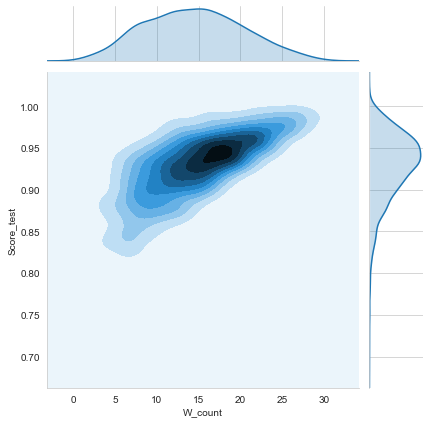

In [153]:
sns.jointplot(x='W_count',y='Score_test',data=test_df,kind='kde')

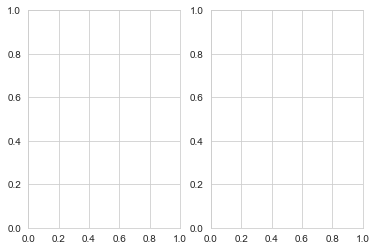

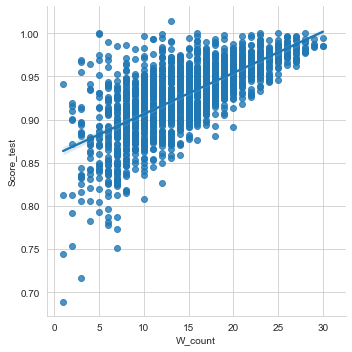

In [120]:
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.lmplot(x='W_count',y='Score_test',data=test_df)

In [154]:
(test_df['Score_test'][:,:][:]>1).sum() / len(test_df)

0.0022766078542970974

In [155]:
RS_1519_dfL.head(1)

,Season,TeamID,Score,NumOT,FGM,FGM3,FTM,OR,DR,Ast,TO,Stl,Blk,PF,weekend_game,szn_rank,upset,sf_q1,sf_half,sf_q3,final_dif,q1_dif,half_dif,q3_dif,offreb_half,defreb_half,steal_half,FGpct,Loc_A,Loc_H,Loc_N,szn_rnk_dif,FG3_pct,FT_pct,FGM2,FG2_pct
60795,2015,1312,48,0,15,6,12,10,28,10,18,4,0,17,0,302.076923,0,5.0,17.0,31.0,17,8.0,19.0,17.0,6.0,15.0,0.0,0.283019,1,0,0,125.384615,0.214286,0.571429,9,0.36


Columns that we dont want an average for:

    weekend_game
    upset
    sf_ columns - want to know for a win vs a loss
    
    
    Average personal foul during a win vs during loss - then look at average
    

In [123]:
def get_data(season, team, column, data_type):
    wcnt = RS_W_aggs[column,'count'][season,team]
    lcnt = RS_L_aggs[column,'count'][season,team]
    tcnt = wcnt + lcnt
    
    if column in ['Score','']:
        W = RS_W_aggs[column,data_type][season,team]
        L = RS_W_aggs[column,data_type][season,team]
        val = ((W*wcnt) + (L*lcnt)) / tcnt
    else:
        
    
    return val
    
def make_RS_cols(data):
    for col in data.columns:
        df15_19[f'RS_{col}'] = data.apply(lambda x: ) +

IndentationError: expected an indented block (<ipython-input-123-cb3fe7c84edb>, line 13)

In [ ]:
data_dict['MRegularSeasonCompactResults'].groupby(['Season', 'WTeamID']).agg({'WScore':['sum', 'count','mean']})

In [ ]:
data_dict['MNCAATourneyDetailedResults'].head()

In [ ]:
data_dict['MTeamConferences']['ConfAbbrev'].unique()

In [ ]:
data_dict['MConferenceTourneyGames']['ConfAbbrev'].unique()

In [ ]:
loc_dums = pd.get_dummies(reg_szn_ro['WLoc'], prefix='WLoc', drop_first=True)
reg_szn_ro = pd.concat([reg_szn_ro, loc_dums], axis=1)
reg_szn_ro.drop('WLoc', axis=1, inplace=True)

In [ ]:
# we want to view all of the columns to see what we need to do with them
pd.set_option('display.max_columns', None)
reg_szn_ro.head()

### Trying out different features with players

In [ ]:
Event_df.head()

In [ ]:
Mplayers.set_index('PlayerID', inplace=True)

In [ ]:
Mplayers.head()

In [ ]:
injuries = pd.read_csv('data/MEvents_NCAA_2020_Comp/nba-injury-report_2020.csv')
injuries.drop('Est. Return', axis=1, inplace=True)

In [ ]:
data_dict['MTeams'][data_dict['MTeams']['TeamID']==1277]

In [ ]:
injuries[injuries['Status']=='Out For Season'].head()

In [ ]:
pts_made = Event_df[(Event_df['Season']==2018) & ((Event_df['EventType'] == 'made2') | (Event_df['EventType'] == 'made2'))]['EventPlayerID'].value_counts()

In [ ]:
pts_made.head()

In [ ]:
sns.distplot(pts_made, bins=30, axlabel='Points Made')

In [ ]:
Event_df[Event_df['EventPlayerID']]

In [ ]:
# Lets create a model quickly